In [0]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss, confusion_matrix
import matplotlib.pyplot as plt

np.random.seed(100)
LEVEL = 'level_1'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
class SigmoidNeuron:
  
  def __init__(self):
    self.w = None
    self.b = None
    
  def perceptron(self, x):
    return np.dot(x, self.w.T) + self.b
  
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  
  def grad_w_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred) * x
  
  def grad_b_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred)
  
  def grad_w_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred * x
    elif y == 1:
      return -1 * (1 - y_pred) * x
    else:
      raise ValueError("y should be 0 or 1")
    
  def grad_b_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred 
    elif y == 1:
      return -1 * (1 - y_pred)
    else:
      raise ValueError("y should be 0 or 1")
  
  def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True, loss_fn="mse", display_loss=False):
    
    # initialise w, b
    if initialise:
      self.w = np.random.randn(1, X.shape[1])
      self.b = 0
      
    if display_loss:
      loss = np.zeros((epochs,1))
    
    for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dw = 0
      db = 0
      for x, y in zip(X, Y):
        if loss_fn == "mse":
          dw += self.grad_w_mse(x, y)
          db += self.grad_b_mse(x, y) 
        elif loss_fn == "ce":
          dw += self.grad_w_ce(x, y)
          db += self.grad_b_ce(x, y)
      self.w -= learning_rate * dw
      self.b -= learning_rate * db
      
      if display_loss:
        Y_pred = self.sigmoid(self.perceptron(X))
        if loss_fn == "mse":
          loss[i,0] = mean_squared_error(Y, Y_pred)
        elif loss_fn == "ce":
          loss[i,0] = log_loss(Y, Y_pred)
    
    if display_loss:
      plt.plot(loss)
      plt.xlabel('Epochs')
      if loss_fn == "mse":
        plt.ylabel('Mean Squared Error')
      elif loss_fn == "ce":
        plt.ylabel('Log Loss')
      plt.show()
      
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.sigmoid(self.perceptron(x))
      Y_pred.append(y_pred)
    return np.array(Y_pred)

In [0]:
def read_all(folder_path, key_prefix=""):
    '''
    It returns a dictionary with 'file names' as keys and 'flattened image arrays' as values.
    '''
    print("Reading:")
    images = {}
    files = os.listdir(folder_path)
    for i, file_name in tqdm_notebook(enumerate(files), total=len(files)):
        file_path = os.path.join(folder_path, file_name)
        image_index = key_prefix + file_name[:-4]
        image = Image.open(file_path)
        image = image.convert("L")
        images[image_index] = np.array(image.copy()).flatten()
        image.close()
    return images

In [8]:
languages = ['ta', 'hi', 'en']
trainPath = "/content/drive/My Drive/PadhAI/"+LEVEL+"_train/"+LEVEL+"/"
testPath = "/content/drive/My Drive/PadhAI/"+LEVEL+"_test/kaggle_"+LEVEL
images_train = read_all(trainPath+"background", key_prefix='bgr_') # change the path
for language in languages:
  images_train.update(read_all(trainPath+language, key_prefix=language+"_" ))
print(len(images_train))

images_test = read_all(testPath, key_prefix='') # change the path
print(len(images_test))

Reading:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Reading:



Reading:



Reading:



892
Reading:



297


In [0]:
! cd ../input

In [9]:
list(images_test.keys())[:5]

['0', '10', '1', '112', '103']

In [10]:
X_train = []
Y_train = []
for key, value in images_train.items():
    X_train.append(value)
    if key[:4] == "bgr_":
        Y_train.append(0)
    else:
        Y_train.append(1)

ID_test = []
X_test = []
for key, value in images_test.items():
  ID_test.append(int(key))
  X_test.append(value)
  
        
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)

print(X_train.shape, Y_train.shape)
print(X_test.shape)

(892, 256) (892,)
(297, 256)


In [0]:
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


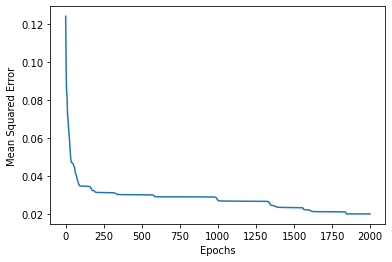

In [17]:
sn_mse = SigmoidNeuron()
sn_mse.fit(X_scaled_train, Y_train, epochs=2000, learning_rate=0.020, loss_fn="mse", display_loss=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


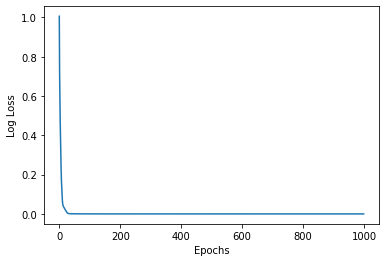

In [20]:
sn_ce = SigmoidNeuron()
sn_ce.fit(X_scaled_train, Y_train, epochs=1000, learning_rate=0.015, loss_fn="ce", display_loss=True)

In [0]:
def print_accuracy(sn):
  Y_pred_train = sn.predict(X_scaled_train)
  Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel()
  accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
  print("Train Accuracy : ", accuracy_train)
  print("-"*50)

In [22]:
print_accuracy(sn_mse)
print_accuracy(sn_ce)

Train Accuracy :  0.9798206278026906
--------------------------------------------------
Train Accuracy :  1.0
--------------------------------------------------


## Sample Submission

In [28]:
X_scaled_test.shape

(297, 256)

In [29]:
Y_pred_test = sn_ce.predict(X_scaled_test)
Y_pred_binarised_test = (Y_pred_test >= 0.5).astype("int").ravel()
Y_pred_binarised_test.shape


(297,)

In [0]:
Y_pred=np.zeros((300,1))

In [0]:
ID=np.zeros((300,1))

In [0]:
for i in range(297):
  x=ID_test[i]
  Y_pred[x,0]=Y_pred_binarised_test[i]
  ID[x,0]=x

In [0]:
ID[19,0]=19
ID[242,0]=242
ID[286,0]=286


In [0]:
submission = {}
submission['ImageId'] = ID[:,0].astype("int")
submission['Class'] = Y_pred[:,0].astype("int")

submission = pd.DataFrame(submission)
submission = submission[['ImageId', 'Class']]
submission = submission.sort_values(['ImageId'])
submission.to_csv("/content/drive/My Drive/PadhAI/submisision.csv", index=False)